In [1]:
import numpy as np
np.random.seed(2016)
%matplotlib inline

import os
import glob
import cv2
import math
import pickle
import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt

from six.moves import xrange

from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss

import tensorflow as tf

In [2]:
###############################################
## Utilities
###############################################

def show_image(im, title='figure'):
    fig = plt.figure()
    if im.shape[2]==1:
        im = im.reshape(im.shape[0],im.shape[1])
        plt.imshow(im,cmap='Greys_r')
    else:
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    fig.suptitle(title, fontsize=20)


def get_im(path, img_rows, img_cols, img_channels):
    # Read Image
    if img_channels == 1:
        img = cv2.imread(path, 0)
    else:
        img = cv2.imread(path)

    # Reduce size
    resized = cv2.resize(img, (img_cols, img_rows), cv2.INTER_LINEAR)
    return resized

def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')


def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data


## Methods to load Train and Test Datasets

1. Read the images (either from cache or disk) in grayscale or 3-channel (BGR format, opencv thing)
2. Resize the images in desireable format, I am using (128 x 96)
3. Reformat into a TensorFlow-friendly shape:
    * convolutions need the image data formatted as a cube (width by height by #channels)
    * labels as float 1-hot encodings.
4. Save in Cache, using pickle. Keep the naming convention, so it's easier to load next time.

** Note: keep images as uint8 instead of float32, while storing. This will take less space**


In [3]:
###############################################
## Load Train and Test
###############################################


def load_train_data(img_rows, img_cols, img_channels):

    # Cache name w.r.t rows cols and channels
    train_cache_name = 'train_'+str(img_rows)+'_'+str(img_cols)+'_'+str(img_channels)+'.dat'

    # Check Cache
    cache_path = os.path.join('cache', train_cache_name)

    if not os.path.isfile(cache_path):
        print('Load train from disk')

        X_train = []
        y_train = []
        for j in range(10):
            print('Load folder c{}'.format(j))
            path = os.path.join('train', 'c' + str(j), '*.jpg')
            files = glob.glob(path)
            for fl in files:
                img = get_im(fl, img_rows, img_cols, img_channels)
                X_train.append(img)
                y_train.append(j)

        #TODO: check if this is necessary
        # Yes this is fine, keep them in uint8
        X_train = np.array(X_train, dtype=np.uint8)
        y_train = np.array(y_train, dtype=np.uint8)

        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)#.astype(np.float32)
        y_train = (np.arange(num_targets) == y_train[:,None]).astype(np.float32)
        cache_data((X_train, y_train), cache_path)
    else:
        print('Restore train from cache!')
        (X_train, y_train) = restore_data(cache_path)

    print('train data shape {} train target shape {}'.format(X_train.shape, y_train.shape))
    return X_train, y_train


def load_test_data(img_rows, img_cols, img_channels):
    # Cache name w.r.t rows cols and channels
    test_cache_name = 'test_'+str(img_rows)+'_'+str(img_cols)+'_'+str(img_channels)+'.dat'

    # Check Cache
    cache_path = os.path.join('cache', test_cache_name)

    if not os.path.isfile(cache_path):
        print('Load test from disk')
        path = os.path.join('test', '*.jpg')
        files = glob.glob(path)
        X_test = []
        X_test_id = []
        total = 0
        start_time = time.time()
        thr = math.floor(len(files)/10)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im(fl,img_rows, img_cols, img_channels)
            X_test.append(img)
            X_test_id.append(flbase)
            total += 1
            if total%thr == 0:
                print('Read {} images from {}'.format(total, len(files)))

        #TODO: check if this is necessary
        # Yes this is fine, keep them in uint8
        X_test = np.array(X_test, dtype=np.uint8)
        X_test_id = np.array(X_test_id, dtype=object)

        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)#.astype(np.float32)

        print('Read test data time: {} seconds'.format(round(time.time() - start_time, 2)))
        cache_data((X_test, X_test_id), cache_path)
    else:
        print('Restore test from cache!')
        (X_test, X_test_id) = restore_data(cache_path)

    print('test data shape {} test id shape {}'.format(X_test.shape, X_test_id.shape))
    return X_test, X_test_id

## Load Train & Test dataset and make sure they look good.

* Uncomment 'Load Test' below if you want test loaded.

In [4]:
# input image dimensions
img_rows, img_cols, img_channels = 96, 128, 1
num_targets = 10

## Load Train
train_data, train_target = load_train_data(img_rows, img_cols, img_channels)

## Load Test
test_data, test_id = load_test_data(img_rows, img_cols, img_channels)


Restore train from cache!
train data shape (22424, 96, 128, 1) train target shape (22424, 10)
Restore test from cache!
test data shape (79726, 96, 128, 1) test id shape (79726,)


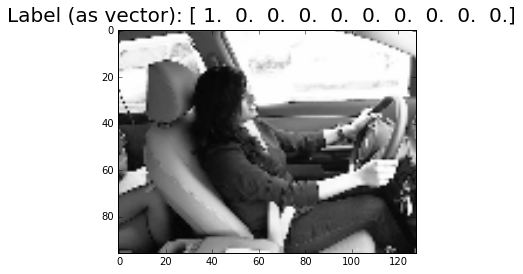

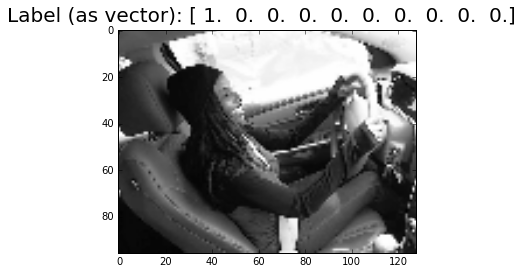

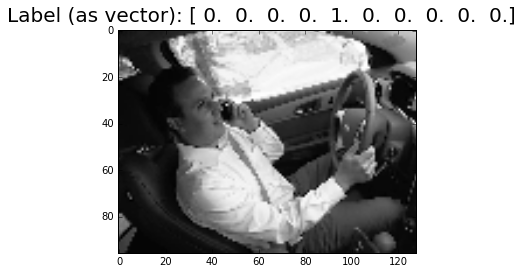

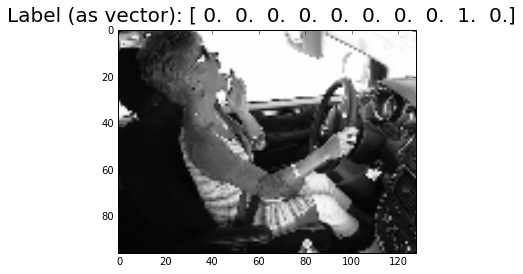

In [5]:
train_idx = [26, 45, 10000, 20000]
images = train_data[train_idx,:]
for idx, im in enumerate(images[:,]):
    title = 'Label (as vector): '+str(train_target[train_idx[idx]])
    show_image(im, title)

In [6]:
#test_idx = 10
#im = test_data[test_idx,:]
#show_image(im)
#print('Test Image name: '+str(test_id[test_idx]))

## Time for some preprocessing

1. Normalize such that the values are between 0-1
2. Also preprocess test data (forgot to do it and got horrible score :P )

TODO: Implement more ideas related to preprocessing.

In [7]:
train_data = train_data.astype('float32')
train_data /= 255

print('Max value: ' + str(np.max(train_data)))
print('Min alue: ' + str(np.min(train_data)))

test_data = test_data.astype('float32')
test_data /= 255

print('Max value: ' + str(np.max(test_data)))
print('Min alue: ' + str(np.min(test_data)))

Max value: 1.0
Min alue: 0.0
Max value: 1.0
Min alue: 0.0


## Split the Training set

1. Simply split the train_data to get train, valid and test sets.

TODO: incorporate drivers' data

In [8]:
random_state = 123
test_size=0.2

# 15% validation data
new_train_data, X_valid, new_train_target, y_valid = train_test_split(train_data, train_target, test_size=test_size, random_state=random_state)

# from the remaining 85% get 15% as hold_out
X_train, X_test, y_train, y_test = train_test_split(new_train_data, new_train_target, test_size=test_size, random_state=random_state)

print('Total Data: ', train_data.shape[0])
print('Split train: ', len(X_train), X_train.shape)
print('Split valid: ', len(X_valid))
print('Split holdout: ', len(X_test))

print('< Final Test Data >')
print('Test Data: ', len(test_data))

Total Data:  22424
Split train:  14351 (14351, 96, 128, 1)
Split valid:  4485
Split holdout:  3588
< Final Test Data >
Test Data:  79726


# Tensorflow Magic

In [9]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [10]:
batch_size = 64
patch_size = 3
depth = 32
num_hidden = 128

EVAL_BATCH_SIZE = 10

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, img_rows, img_cols, img_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_targets))

    ###############################################################
    # Validation and Test dataset batches
    # Because I can not load the whole data (validation or test) due to memory limitations of GPU
    # I'm gonna evaluate the valid & test data in batches of 10
    ###############################################################
    #tf_valid_dataset = tf.constant(X_valid)
    tf_valid_dataset = tf.placeholder(
        tf.float32,
        shape=(EVAL_BATCH_SIZE, img_rows, img_cols, img_channels))
    
    #tf_test_dataset = tf.constant(X_test)
    tf_test_dataset = tf.placeholder(
        tf.float32,
        shape=(EVAL_BATCH_SIZE, img_rows, img_cols, img_channels))
    ###############################################################
    
    tf_dropout_1 = tf.placeholder(tf.float32)
    tf_dropout_2 = tf.placeholder(tf.float32)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, img_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    layer3_weights = tf.Variable(tf.truncated_normal([img_rows // 2 * img_cols // 2 * depth, num_hidden], stddev=0.1))
    # in case we use valid padding
    #layer3_weights = tf.Variable(tf.truncated_normal([46 * 62 * depth, num_hidden], stddev=0.1))
    
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_targets], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_targets]))
  
    # Model.
    def model(data,training=True):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        # 64 x 96 x 128 x 32 with 'SAME' padding
        # 64 x 94 x 126 x 32 with 'VALID' padding
        hidden = tf.nn.relu(conv + layer1_biases)
        
        shape = hidden.get_shape().as_list()
        print('cnv2d-1----------')
        print(shape)
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        # 64 x 96 x 128 x 32 with 'SAME' padding 
        # 64 x 92 x 124 x 32 with 'VALID' padding
        
        hidden = tf.nn.relu(conv + layer2_biases)
        
        shape = hidden.get_shape().as_list()
        print('conv2d-2----------')
        print(shape)
        
        pool = tf.nn.max_pool(hidden, [1,2,2,1], [1,2,2,1], padding='SAME') 
        # 64 x 48 x 64 x 32 with same
        
        shape = pool.get_shape().as_list()
        print('pool-1----------')
        print(shape)
        
        #Only dropout while training
        if training:
            dropout_1 = tf.nn.dropout(pool, tf_dropout_1)
            reshape = tf.reshape(dropout_1, [shape[0], shape[1] * shape[2] * shape[3]])
        else:
            reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        
        #reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        print('Reshape----------')
        print(reshape.get_shape())
        
        
        #Dense
        hidden_dense = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)        
        if training:
            hidden_dense = tf.nn.dropout(hidden_dense, tf_dropout_2)
        
        return tf.matmul(hidden_dense, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    #loss = tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    
    # Optimizer.
    
    # keras default lr for adadelta is 1.0 which I believe is too high 
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=1.0).minimize(loss)
    
    #optimizer = tf.train.AdadeltaOptimizer(learning_rate=0.01).minimize(loss)
    #optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, False))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, False))


cnv2d-1----------
[64, 96, 128, 32]
conv2d-2----------
[64, 96, 128, 32]
pool-1----------
[64, 48, 64, 32]
Reshape----------
(64, 98304)
cnv2d-1----------
[10, 96, 128, 32]
conv2d-2----------
[10, 96, 128, 32]
pool-1----------
[10, 48, 64, 32]
Reshape----------
(10, 98304)
cnv2d-1----------
[10, 96, 128, 32]
conv2d-2----------
[10, 96, 128, 32]
pool-1----------
[10, 48, 64, 32]
Reshape----------
(10, 98304)


In [11]:

def eval_in_batches_valid(data, sess):
    """Get all predictions for a dataset by running it in small batches."""
    size = data.shape[0]
    if size < EVAL_BATCH_SIZE:
      raise ValueError("batch size for evals larger than dataset: %d" % size)
    predictions = np.ndarray(shape=(size, num_targets), dtype=np.float32)
    for begin in xrange(0, size, EVAL_BATCH_SIZE):
      end = begin + EVAL_BATCH_SIZE
      if end <= size:
        predictions[begin:end, :] = sess.run(
            valid_prediction,
            feed_dict={tf_valid_dataset: data[begin:end, ...]})
      else:
        batch_predictions = sess.run(
            valid_prediction,
            feed_dict={tf_valid_dataset: data[-EVAL_BATCH_SIZE:, ...]})
        predictions[begin:, :] = batch_predictions[begin - size:, :]
    return predictions

def eval_in_batches_test(data, sess):
    """Get all predictions for a dataset by running it in small batches."""
    size = data.shape[0]
    if size < EVAL_BATCH_SIZE:
      raise ValueError("batch size for evals larger than dataset: %d" % size)
    predictions = np.ndarray(shape=(size, num_targets), dtype=np.float32)
    for begin in xrange(0, size, EVAL_BATCH_SIZE):
      end = begin + EVAL_BATCH_SIZE
      if end <= size:
        predictions[begin:end, :] = sess.run(
            test_prediction,
            feed_dict={tf_test_dataset: data[begin:end, ...]})
      else:
        batch_predictions = sess.run(
            test_prediction,
            feed_dict={tf_test_dataset: data[-EVAL_BATCH_SIZE:, ...]})
        predictions[begin:, :] = batch_predictions[begin - size:, :]
    return predictions

In [12]:
# I want to run for 2 epochs, which means pass twice on the training data
# 14351 divided by batch size: 64 = 224.3 ~ 225 steps for one epoch

# ~ 550 steps for 2 epochs

num_steps = 550

# in tensorflow dropout means 'keep probability' unlike keras
# 1.0 means there will be no dropouts
dropout_1 = 0.75
dropout_2 = 0.5

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (X_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_dropout_1 : dropout_1, tf_dropout_2 : dropout_2}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), y_valid))
            print('Validation accuracy: %.1f%%' % accuracy(eval_in_batches_valid(X_valid, session), y_valid))
    print('Test accuracy: %.1f%%' % accuracy(eval_in_batches_test(X_test, session), y_test))
    
    #predictions = eval_in_batches_test(test_data, session)

Initialized
Minibatch loss at step 0: 42.604836
Minibatch accuracy: 15.6%
Validation accuracy: 9.5%
Minibatch loss at step 100: 2.323065
Minibatch accuracy: 4.7%
Validation accuracy: 9.5%
Minibatch loss at step 200: 2.282989
Minibatch accuracy: 10.9%
Validation accuracy: 9.5%
Minibatch loss at step 300: 2.290025
Minibatch accuracy: 10.9%
Validation accuracy: 10.8%
Minibatch loss at step 400: 2.319762
Minibatch accuracy: 12.5%
Validation accuracy: 9.6%
Minibatch loss at step 500: 2.299996
Minibatch accuracy: 7.8%
Validation accuracy: 11.1%
Test accuracy: 10.0%


In [13]:
def create_submission(predictions, test_id):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    #suffix = str(round(loss, 6)) + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'tf_keras_submission.csv')
    result1.to_csv(sub_file, index=False)

#create_submission(predictions, test_id)